# Natality Experiment on the DAME-FLAME Python Package

I use the DAME-FLAME Python package, which is publicly available for download [here](https://pypi.org/project/dame-flame/), on a real dataset, aiming to examine the effect of "extreme smoking" during pregancy on a newborn's birthweight. Overall, the results of the DAME-FLAME package lead us to believe that smoking during pregnancy causes significantly lower birthweight of infants. It also leads us to believe that there is little to no heterogeneity in *conditional treatment effects* of a mother's smoking on birthweight. In other words, when we examine groupings of characteristics of mothers and infants (including race, gender of infant, etc), then we don't see evidence that there exists some mothers and infants for whom the impact of maternal smoking on infant birthweight is different than the outcomes for other types of mothers and infants. 

I use the 2010 US Natality dataset from the National Vital Statistics System of the National Center for Health Statistics (2010), available here: http://www2.nber.org/data/vital-statistics-natality-data.html.
The accompanying user guide to the dataset is also linked on this URL, as "documentation". 

This code and analysis was written by Neha Gupta, following similar work done by Tianyu Wang, in the paper [FLAME: A Fast Large-scale Almost Matching Exactly Approach to Causal Inference](https://arxiv.org/abs/1707.06315). Notable differences between the two are that the latter uses a slightly modified algorithm (Wang uses FlameDB, I use FlameBit), and this experiment drops all units that have missing data rather than matching on units with missing data while skipping matching on missing covariates (Both options are available in the `dame-flame` package! Use the `missing_data_replace` parameter). I also cut back on the dataset size for processing time. 

This experiment aims to build upon the analysis on maternal smoking and infant birthweight shown in [Kondracki (2020)](https://link.springer.com/content/pdf/10.1186/s12884-020-02981-1.pdf). 

For questions on this code, or on the DAME-FLAME Python Package, please contact Neha at neha.r.gupta "at" duke "dot" edu. 

In [1]:
import pandas as pd
import numpy as np
import dame_flame
import random
import matplotlib.pyplot as plt

## Data Cleaning 
We begin by reading in the data file from the URL and cleaning it. We take a randomly chosen small sample, the variable `p`, for this experiment. 

In [2]:
p = 0.1

df = pd.read_csv('http://data.nber.org/natality/2010/natl2010.csv.zip',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p)

/home/home1/nrg18/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (28,55,60,61,62,63,64,65,66,67,68,69,70,71,77,78,79,80,83,84,85,86,87,88,89,90,91,92,93,99,104,105,106,107,108,109,111,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,158,159,160) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Restrict to singular births only. This is the DPLURAL variable
df = df[df['dplural'] == 1]

# need to also restrict to standard term births. This is 37 weeks+, as defined by Kondracki (2020)
df = df[df['gestrec3'] == 2]

# These are missing from the weight, I presume from the User Guide. 
df = df[df['dbwt'] != 9999]

Below, I recode cigarette usage. I follow [Kondracki (2020)](https://link.springer.com/content/pdf/10.1186/s12884-020-02981-1.pdf) and define "extreme smoking" as 10+ cigarettes per day for the duration of preganancy. I will use this as the treatment indicator, and the control group will be individuals who smoked 0 cigarettes per day for the duration of the pregnancy. The dataset encodes cigarette usage for each trimester of pregnancy differently, so I gather from each variable. 

In [4]:
# First, drop anyone for whom we don't have smoking data:
df = df[df['cig_1'] != 99]
df = df[df['cig_2'] != 99]
df = df[df['cig_3'] != 99]

df['smokes_10'] = np.where(((df['cig_1'] >= 10) & (df['cig_2'] >=10) & (df['cig_3'] >= 10)), 1, 0)
df['nonsmoker'] = np.where(((df['cig_1'] == 0) & (df['cig_2'] == 0) & (df['cig_3'] == 0)), 1, 0)

# if you're not smoking 10 and you're not a nonsmoker then these two values will both be 0. We remove where they're equal. 
df = (df[df['nonsmoker'] != df['smokes_10']])

I remove many observational covariates from the original dataset. The variables names here are the exact variable names in the original dataset, so they can be searched for in the [User Guide](http://data.nber.org/natality/2010/natl2010.pdf). More details on the meaning are available there. Briefly, I summarize the variables below. Note that some of these variables are recoded and could be considered "binned" continuous variables. The `DAME-FLAME` package is only for discrete observational datasets, but there are acceptable forms of data binning for some research questions. In this case, we assume binning these variables is acceptable because of prior research that relies on binned data such as [Kondracki (2020)](https://link.springer.com/content/pdf/10.1186/s12884-020-02981-1.pdf). For example, data that is binned include fathers age into fixed width bins in intervals of 5 years, and mother's education into bins of degree obtained rather than years of study. There is substantial research precedence that uses educational degree obtained as a variable on outcome rather than years of study. 

| Variable Name | Meaning |
| ------------- | ------- |
| fagerec11 | Fathers Age Recoded |
| meduc | Mothers Education |
| dob_wk | Weekday |
| mager9 | Mother's Age Recode 9 |
| fbrace | Father's Race |
| mar | Mother's marital status |
| rf_diab | Pre-pregnancy diabetes |
| rf_cesar | Previous Cesarean Deliveries |
| tbo_rec | Total Birth Order |
| rf_phyp | Prepregnancy hypertension |
| urf_chyper | chronic hypertension |
| lbo_rec | live birth order |
| rf_ppterm | previous preterm birth |
| sex | Sex of Infant |
| mbrace | Mother's bridged race |
| bfacil3 | Birth Place (home, hospital) |
| dbwt | Infant's birthweight |

In [5]:
df_trunc = df.loc[:, df.columns.intersection(['fagerec11', 'meduc', 'dob_wk', 'mager9',
                                    'fbrace', 'mar','rf_diab', 'rf_cesar', 
                                  'tbo_rec', 'rf_phyp', 'urf_chyper', 'lbo_rec',
                                  'rf_ppterm', 'sex', 'mbrace', 'bfacil3', 'smokes_10', 'dbwt'])]

In [6]:
# Missing values are encoded differently throughout the dataset (see user guide), but I aim to encode them all with the 999 character

df_trunc.loc[df_trunc['bfacil3'] == 9, 'bfacil3'] = np.nan
df_trunc.loc[df_trunc['mar'] == 9, 'mar'] = np.nan
df_trunc.loc[df_trunc['meduc'] == 9, 'meduc'] = np.nan
df_trunc.loc[df_trunc['fagerec11'] == 11, 'fagerec11'] = np.nan
df_trunc.loc[df_trunc['fbrace'] == 99, 'fbrace'] = np.nan
df_trunc.loc[df_trunc['lbo_rec'] == 9, 'lbo_rec'] = np.nan
df_trunc.loc[df_trunc['tbo_rec'] == 9, 'tbo_rec'] = np.nan
df_trunc.loc[df_trunc['urf_chyper'] == 9, 'urf_chyper'] = np.nan

# Need to transform all the "N" and "Y" to 0/1
d = {"N": 0, "Y": 1, "U": np.nan}
df_trunc['rf_diab'] = df_trunc['rf_diab'].map(d)
df_trunc['rf_phyp'] = df_trunc['rf_phyp'].map(d)
df_trunc['rf_ppterm'] = df_trunc['rf_ppterm'].map(d)
df_trunc['rf_cesar'] = df_trunc['rf_cesar'].map(d)

# Transforming Gender to boolean
d = {"F":1, "M": 0}
df_trunc['sex'] = df_trunc['sex'].map(d)

# Make sure all clear for input to DAME-FLAME package
df_trunc = df_trunc.dropna()
df_trunc = df_trunc.astype(int)

In [7]:
df_trunc.head()

,dob_wk,bfacil3,mager9,mbrace,mar,meduc,fagerec11,fbrace,lbo_rec,tbo_rec,rf_diab,rf_phyp,rf_ppterm,rf_cesar,urf_chyper,sex,dbwt,smokes_10
19864,6,1,3,1,1,3,5,1,2,2,0,0,0,0,2,0,3544,0
19865,1,2,7,21,1,4,8,1,3,3,0,0,0,0,2,0,3487,0
19866,6,1,5,5,1,6,5,5,1,1,0,0,0,0,2,0,2642,0
19867,7,1,5,8,1,7,5,8,1,1,0,0,0,0,2,0,3220,0
19869,1,1,6,1,1,1,7,1,3,3,0,0,0,0,2,1,3118,0


In [8]:
# This is the number of smokers and non-smokers in the dataset:
df_trunc['smokes_10'].value_counts()

0    169577
1      5251
Name: smokes_10, dtype: int64

## Create treatment/control matches with the DAME-FLAME package

In [9]:
# extreme smoking is the treatment column, birthweight is the outcome
model_flame = dame_flame.matching.FLAME(repeats=False, verbose=3, adaptive_weights='decisiontreeCV')
model_flame.fit(holdout_data=df_trunc, treatment_column_name='smokes_10', outcome_column_name='dbwt')
result_flame = model_flame.predict(df_trunc)

Iteration number:  1
	Number of matched groups formed in total:  2408
	Unmatched treated units:  2052 out of a total of  5251 treated units
	Unmatched control units:  139666 out of a total of  169577 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  33110
	Number of matches made so far:  33110
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  3173
	Unmatched treated units:  1222 out of a total of  5251 treated units
	Unmatched control units:  136968 out of a total of  169577 control units
	Predictive error of covariates chosen this iteration:  608255.8314184071
	Number of matches made in this iteration:  3528
	Number of matches made so far:  36638
	In this iteration, the covariates dropped are:  dob_wk
Iteration number:  3
	Number of matched groups formed in total:  3680
	Unmatched treated units:  670 out of a total of  5251 treated units
	Unmatched co

## Plot and Discuss Outcome

The covariate dropping order, shown above using the `verbose=3` parameter, is something we can try to use to interpret covariate importance. The FLAME algorithm learns the importance of each covariate on the outcome when choosing the best covariate to drop. Thus, the earlier dropped covariates are less relevant to the outcome. In this case, FLAME would lead us to believe that some factors, such as mother's education and the day of the week of the infant birth, are less predictive of an infant's birth weight than other factors, such as the sex of the infant.

In [10]:
dame_flame.utils.post_processing.ATE(model_flame)

-219.36514154344763

So, as we can see, the ATE is highly negative, implying that maternal extreme smoking causes an infant birthweight to be lower than not-smoking by this many grams. 

In [11]:
group_size_treated = []
group_size_overall = []
cate_of_group = []
for group in model_flame.units_per_group:
    
    # find len of just treated units
    df_mmg = df.loc[group]
    treated = df_mmg.loc[df_mmg["smokes_10"] == 1]
    
    group_size_treated.append(len(treated))
    group_size_overall.append(len(group))
    
    cate_of_group.append(dame_flame.utils.post_processing.CATE(model_flame, group[0]))

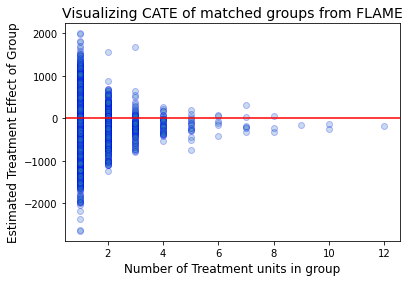

In [13]:
plt.scatter(group_size_treated, cate_of_group, alpha=0.25, edgecolors='b')
plt.axhline(y=0.0, color='r', linestyle='-')
plt.xlabel('Number of Treatment units in group', fontsize=12)
plt.ylabel('Estimated Treatment Effect of Group', fontsize=12)
plt.title("Visualizing CATE of matched groups from FLAME", fontsize=14)
plt.savefig('interpretability.png')

This plot leads us to believe there is little heterogeneity in the Conditional Average Treatment Effect (CATE) of maternal smoking on infant birth weight. Most extreme values are observed in small matched groups, for which CATE estimation is difficult. Put simply, we don't see sufficient evidence that there exists some "types of" mothers and infants (classified by characteristics such as education and race) for whom the impact of maternal smoking on infant birthweight is different than the outcomes for other mothers and infants. 